In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch

import boda

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210623_102310__205717.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

Loaded model from 20210623_102310 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=[9, 9], value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=[5, 5], value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=[3, 3], value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [3]:
left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
left_flank.shape

torch.Size([1, 4, 200])

In [4]:
right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
right_flank.shape

torch.Size([1, 4, 200])

In [5]:
bsz = 6

theta = boda.generator.GumbelSoftmaxParameters(
    torch.nn.Parameter(torch.randn(bsz,4,200)),
    left_flank =left_flank.repeat(bsz,1,1),
    right_flank=right_flank.repeat(bsz,1,1),
    n_samples=10,
    prior_var=4.
)

print(f"parameters shape: {theta.shape}")
print(f"sampled shape: {theta.get_sample().shape}")
print(f"flat samples shape: {theta().shape}")
print(f"rebatch shape: {theta.rebatch(theta()).shape}")
theta.cuda()

parameters shape: torch.Size([6, 4, 600])
sampled shape: torch.Size([10, 6, 4, 600])
flat samples shape: torch.Size([60, 4, 600])
rebatch shape: torch.Size([6, 4, 600])


GumbelSoftmaxParameters(
  (softmax): Softmax(dim=-1)
)

In [28]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, bias_cell=None):
        super().__init__()
        
        self.model = model
        self.bias_cell = bias_cell
        self.model.eval()
        
    def forward(self, x):
        
        hook = self.model(x.to(self.model.device))
        
        if self.bias_cell is None:
            return boda.graph.utils.shannon_entropy(hook)
        else:
            return hook[:,[ i for i in range(hook.shape[1]) if i != self.bias_cell ]].mean(1) - hook[:,self.bias_cell]

In [7]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, bias_cell):
        super().__init__()
        
        self.model = model
        self.bias_cell = bias_cell
        self.model.eval()
        
        self.targ = torch.zeros((1,3)).add(0.05).to(self.model.device)
        self.targ[0,self.bias_cell].add_(0.85)
        
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.loss = torch.nn.KLDivLoss(reduction='none')
        
    def forward(self, x):
        
        hook = self.model(x.to(self.model.device))
        hook = self.softmax(hook)
        hook = self.loss( hook, self.targ.repeat(hook.shape[0],1) ).sum(1)
        return hook
        

In [8]:
my_energy = MyEnergy(my_model, 0)

print( f"energies shape {my_energy(theta()).shape}" )
print( f"rebatched energies {theta.rebatch(my_energy(theta())).shape}" )
my_energy(theta())

energies shape torch.Size([60])
rebatched energies torch.Size([6])


tensor([0.3635, 0.3696, 0.7750, 0.5249, 0.7689, 0.3497, 0.9203, 0.5071, 0.4036,
        0.6608, 0.8492, 0.7751, 0.6545, 0.6723, 0.8044, 0.5883, 0.7166, 0.5365,
        0.6319, 0.6476, 0.4114, 1.1004, 0.7213, 0.6053, 0.6722, 0.9468, 0.7014,
        0.9919, 0.6663, 0.6592, 0.5232, 0.6926, 0.3124, 0.0747, 0.5730, 0.5557,
        0.6547, 0.6223, 0.8620, 0.6811, 0.9594, 0.7594, 0.5358, 0.6372, 0.7889,
        0.3431, 0.4895, 0.7001, 0.7649, 0.4864, 0.5386, 0.5361, 0.7685, 0.5736,
        0.6084, 0.5983, 0.7465, 0.8490, 0.3963, 0.4548], device='cuda:0',
       grad_fn=<SumBackward1>)

In [9]:
my_sampler = boda.generator.HMC( theta, my_energy )
theta.shape

torch.Size([6, 4, 600])

In [34]:
%%time
my_samples = my_sampler.collect_samples(epsilon=torch.ones((6,1,1)).mul(1e-1).to(theta.theta.device), 
                                        L=1,inertia=1.,n_samples=1000,n_burnin=0)


/home/ubuntu/boda2/boda/generator/nuts.py:30: RuntimeWarning: Prior Negative Log-Likelihood Not Implemented.
  warnings.warn("Prior Negative Log-Likelihood Not Implemented.", RuntimeWarning)


CPU times: user 25.9 s, sys: 129 ms, total: 26 s
Wall time: 25.9 s


In [18]:
[ x['epsilon'].squeeze().cpu().numpy() for x in my_samples['burnin'] ]

[]

In [35]:
sampled_theta = torch.stack([ x['params'] for x in my_samples['samples'] ], dim=0)
sampled_energy= torch.stack([ x['energy'] for x in my_samples['samples'] ], dim=0)

In [68]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [20]:
sampled_energy.shape[0]

1000

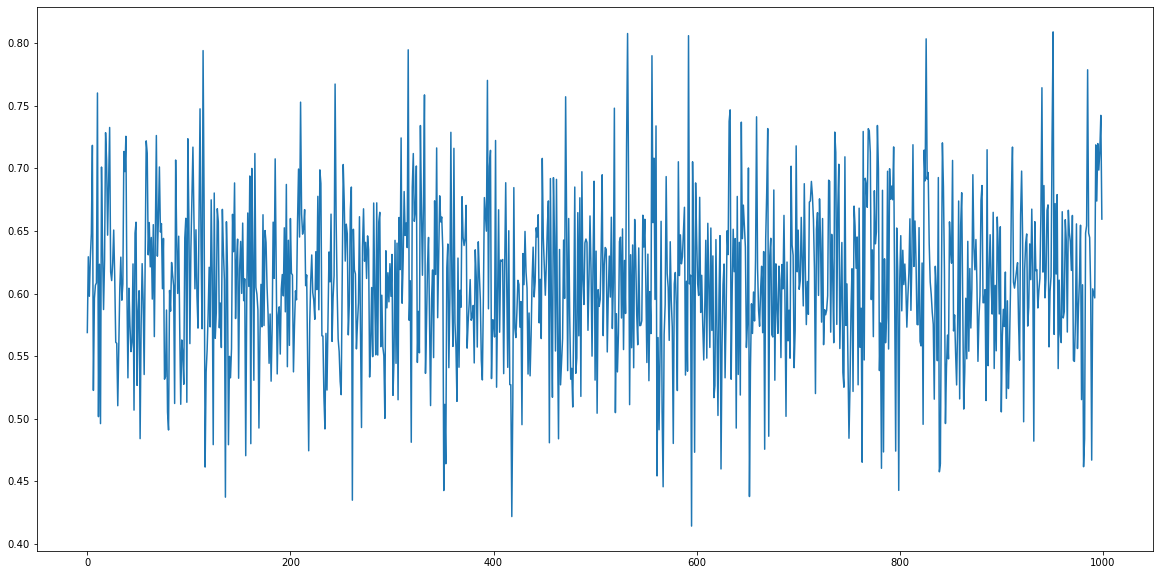

In [36]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(sampled_energy.shape[0]),sampled_energy[:,1].cpu().numpy())

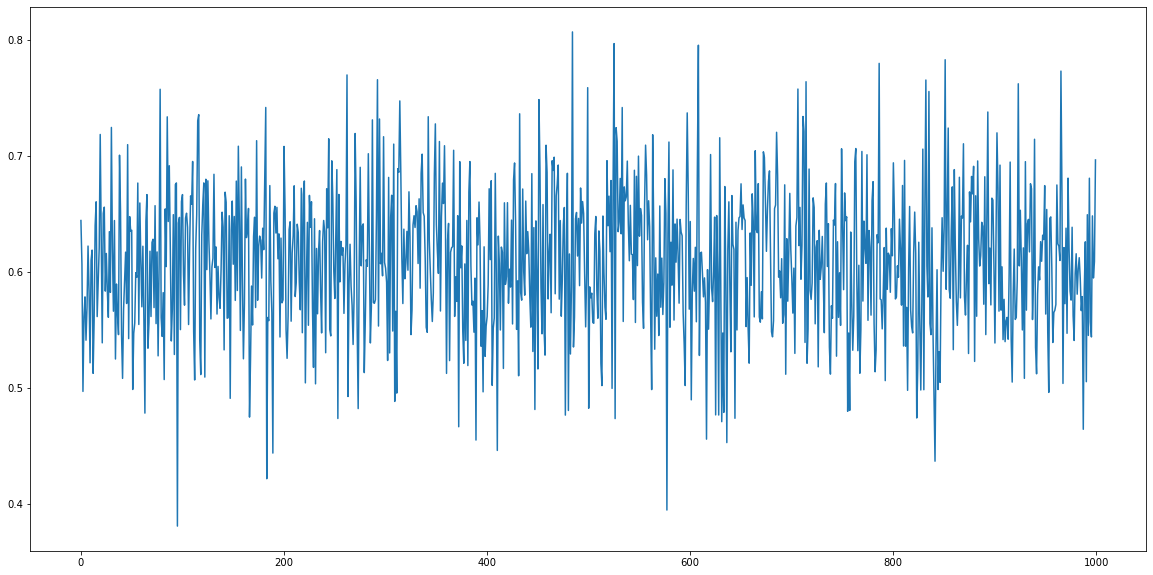

In [33]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(sampled_energy.shape[0]),sampled_energy[:,1].cpu().numpy())

In [18]:
x = torch.stack([torch.ones(5).mul(1), torch.ones(5).mul(3), torch.ones(5).mul(5)], dim=0)
y = torch.stack([torch.ones(5).mul(2), torch.ones(5).mul(4), torch.ones(5).mul(6)], dim=0)

z = torch.tensor([True, False, True]).long()

torch.stack((x,y), dim=0)[z,torch.arange(x.shape[0])]

tensor([[2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [6., 6., 6., 6., 6.]])

In [55]:
a = torch.randn(3)
b = torch.rand(3)
c = 3.0
print(a)
print(b)
print(c)

tensor([-0.3904,  0.6156,  0.8876])
tensor([0.0380, 0.6294, 0.8306])
3.0


In [56]:
b[a < -1.2] *= 0.5
b[(a >= -1.2) & (a < 1.2)] *= 0.5
b[a >= 1.2] *= 2.0
b

tensor([0.0190, 0.3147, 0.4153])

In [57]:
c[a < -1.2] *= 0.5

TypeError: 'float' object is not subscriptable